In [1]:
import tqdm
from transformers import AutoTokenizer, AutoModel
import json

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

In [ ]:
def get_abstract(paper):
    return paper['AbstractText']

json_files = ['metadata_Alzheimers.json', 'metadata_cancer.json']
papers = {}
for file in json_files:
    with open(file, 'r', encoding='utf-8') as f:
        cur_papers = json.load(f)
        papers.update(cur_papers)

embeddings = {}
for pmid, paper in tqdm.tqdm(papers.items()):
    data = [paper["ArticleTitle"] + tokenizer.sep_token + get_abstract(paper)]
    inputs = tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

# turn our dictionary into a list
embeddings = [embeddings[pmid] for pmid in papers.keys()]

100%|██████████| 1995/1995 [08:31<00:00,  3.90it/s]


In [ ]:
from sklearn import decomposition
import pandas as pd

pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
# embeddings_pca["query"] = [paper["query"] for paper in papers.values()]
embeddings_pca_query = []
for id, paper in papers.items():
    if id in ['40949928', '40326981', '40800467', '40395755']:
        embeddings_pca_query.append('Overlap')
    else:
        embeddings_pca_query.append(paper["query"])
embeddings_pca['query'] = embeddings_pca_query

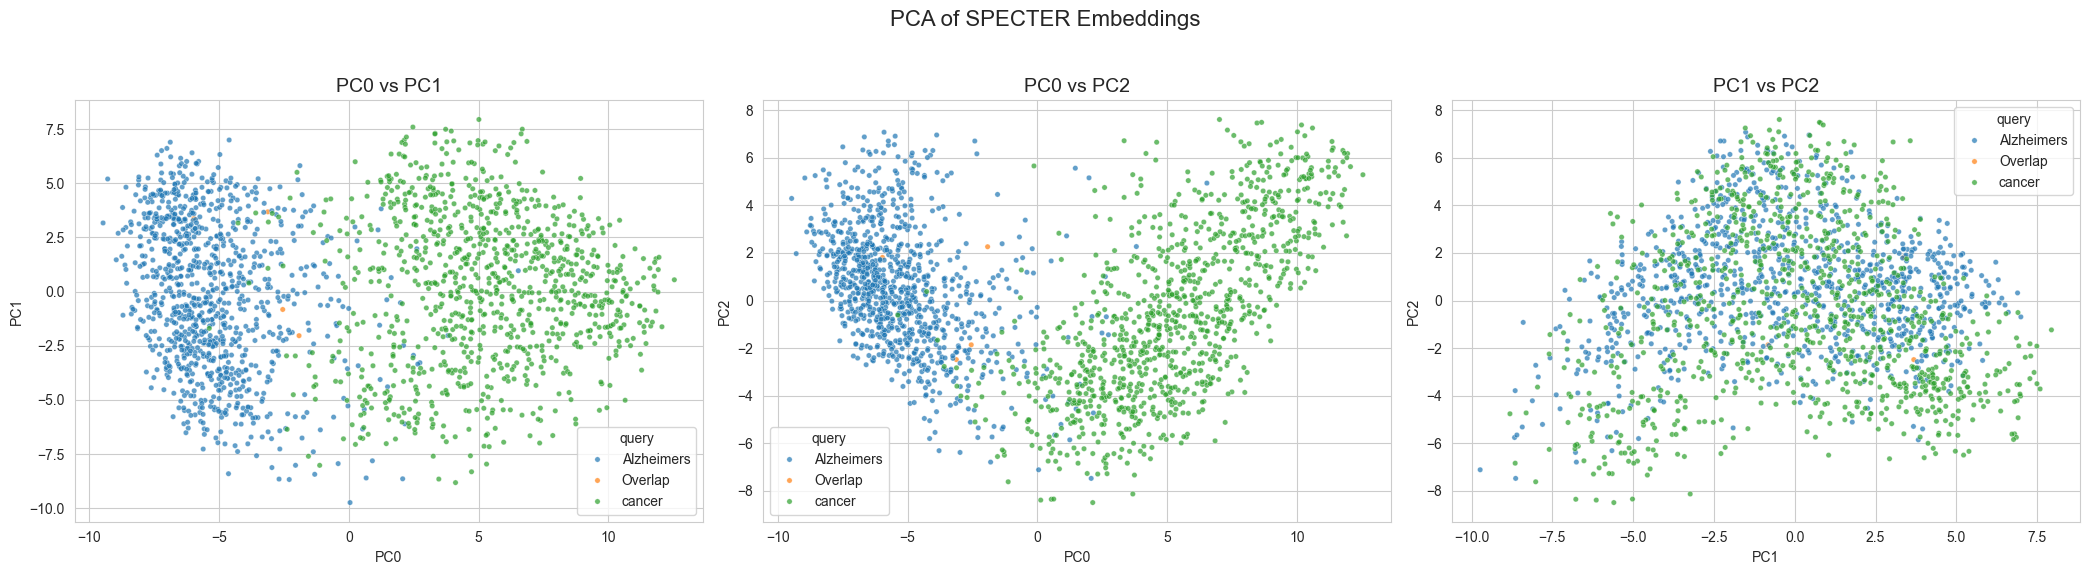

Saved 2D plots to 'pca_plots_2d.png'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle('PCA of SPECTER Embeddings', fontsize=16)

# --- Plot 1: PC0 vs PC1 ---
sns.scatterplot(
    data=embeddings_pca, 
    x='PC0', 
    y='PC1', 
    hue='query',
    ax=axes[0],
    s=15,
    alpha=0.7
)
axes[0].set_title('PC0 vs PC1', fontsize=14)

# --- Plot 2: PC0 vs PC2 ---
sns.scatterplot(
    data=embeddings_pca, 
    x='PC0', 
    y='PC2', 
    hue='query', 
    ax=axes[1],
    s=15, 
    alpha=0.7
)
axes[1].set_title('PC0 vs PC2', fontsize=14)

# --- Plot 3: PC1 vs PC2 ---
sns.scatterplot(
    data=embeddings_pca, 
    x='PC1', 
    y='PC2', 
    hue='query', 
    ax=axes[2],
    s=15, 
    alpha=0.7
)
axes[2].set_title('PC1 vs PC2', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("pca_plots_2d.png", dpi=150)
plt.show()